In [5]:
!pip install 'sagemaker>=2,<3'

In [6]:
%%time
import sagemaker
from sagemaker import get_execution_role
 
role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::241018688765:role/service-role/AmazonSageMaker-ExecutionRole-20200403T163653
CPU times: user 542 ms, sys: 62.3 ms, total: 605 ms
Wall time: 760 ms


In [7]:
training_image = sagemaker.image_uris.retrieve('semantic-segmentation', sess.boto_region_name)
print(training_image)

813361260812.dkr.ecr.eu-central-1.amazonaws.com/semantic-segmentation:1


In [8]:
augmented_manifest_filename_train = 'output_train.manifest' # Replace with the filename for your training data.
augmented_manifest_filename_validation = 'output_val.manifest' # Replace with the filename for your validation data.
bucket_name = "sagemaker-awsdemo-marketing" # Replace with your bucket name.
s3_prefix_train = 'landcover.ai-dataset/labeled_images_sample/manifest_train' # Replace with the S3 prefix where your train data files reside.
s3_prefix_val = 'landcover.ai-dataset/labeled_images_sample/manifest_val' # Replace with the S3 prefix where your validation data files reside.
s3_output_path = 's3://{}/sample_output'.format(bucket_name) # Replace with your desired output directory.
print(s3_output_path)

s3://sagemaker-awsdemo-marketing/sample_output


In [9]:
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(bucket_name, s3_prefix_train, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(bucket_name, s3_prefix_val, augmented_manifest_filename_validation)

print("Augmented manifest for training data: {}".format(s3_train_data_path))
print("Augmented manifest for validation data: {}".format(s3_validation_data_path))

Augmented manifest for training data: s3://sagemaker-awsdemo-marketing/landcover.ai-dataset/labeled_images_sample/manifest_train/output_train.manifest
Augmented manifest for validation data: s3://sagemaker-awsdemo-marketing/landcover.ai-dataset/labeled_images_sample/manifest_val/output_val.manifest


In [ ]:
# Create a model object set to using "Pipe" mode.
model = sagemaker.estimator.Estimator(training_image,
                                      role,
                                      instance_count=1,
                                      instance_type='ml.p3.2xlarge',
                                      volume_size = 50,
                                      max_run = 360000,
                                      input_mode = 'Pipe',
                                      output_path=s3_output_path,
                                      sagemaker_session=sess)

# Setup hyperparameters 
model.set_hyperparameters(
    backbone='resnet-50',  # This is the encoder. Other option is resnet-101
    algorithm='fcn',  # This is the decoder. Other options are 'psp' and 'deeplab'                             
    use_pretrained_model='True',  # Use the pre-trained model.
    crop_size=240,  # Size of image random crop.                             
    num_classes=4,  # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10,  # Number of epochs to run.
    learning_rate=0.0001,
    optimizer='rmsprop',  # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly',  # Other options include 'cosine' and 'step'.                           
    mini_batch_size=8,  # Setup some mini batch size.
    validation_mini_batch_size=2,
    early_stopping=True,  # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=2,  # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10,  # No matter what, run these many number of epochs.                             
    num_training_samples=24,  # This is a mandatory parameter, 1464 in this case.
)


# Create a train data channel with S3_data_type as 'AugmentedManifestFile' and attribute names.
train_data = sagemaker.session.s3_input(s3_train_data_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'aws-demo-ref'],
                                        input_mode='Pipe',
                                        record_wrapping='RecordIO') 

validation_data = sagemaker.session.s3_input(s3_validation_data_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'aws-demo-ref'],
                                        input_mode='Pipe',
                                        record_wrapping='RecordIO') 

data_channels = {'train': train_data, 'validation': validation_data}

# Train a model.
#model.fit(inputs=data_channels, logs=True)

In [10]:
# deploy model to an endpoint
#deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge')

# use deployed model
deployed_model = sagemaker.predictor.Predictor("semantic-segmentation-2021-02-10-14-20-35-309")

In [11]:
filename_raw  = "Images/test1.png"

In [ ]:
# rescale high resolution images

import PIL
%matplotlib inline

filename = '/home/ec2-user/SageMaker/621651905_resized.jpg'
width = 800

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

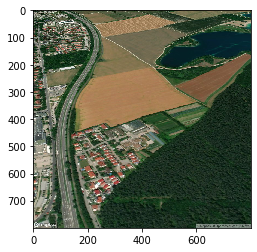

In [12]:
# View original image
import PIL
import matplotlib.pyplot as plt
%matplotlib inline

im = PIL.Image.open(filename_raw)
plt.imshow(im)
plt.show()

In [13]:
from PIL import Image
import numpy as np

class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""
    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


deployed_model.deserializer = ImageDeserializer(accept="image/png")
deployed_model.serializer = sagemaker.serializers.IdentitySerializer('image/jpeg')

In [14]:
with open(filename_raw, 'rb') as imfile:
    imbytes = imfile.read()

In [15]:
results = deployed_model.predict(imbytes)

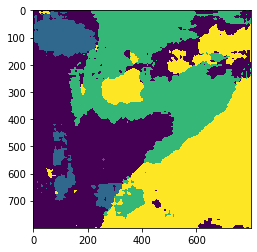

In [16]:
plt.imshow(results)
plt.show()

In [17]:
# save masked image
import matplotlib
matplotlib.image.imsave('Images/test1_masked.png', results)